# 线性分类器-MINST
09118241 陈嘉源

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import random
import csv

def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()
    # 解析文件头信息，依次为模数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)  
    fmt_image = '>' + str(image_size) + 'B' 
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images

def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为模数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


## 加载数据集 train_data/train_label/test_data

In [2]:
# 加载数据集
print("加载数据集...")
train_images_file = './train-images-idx3-ubyte'
train_labels_file = './train-labels-idx1-ubyte'
test_images_file = './t10k-images-idx3-ubyte'

train_images = decode_idx3_ubyte(train_images_file)
train_labels = decode_idx1_ubyte(train_labels_file)
test_images = decode_idx3_ubyte(test_images_file)
print('done')

加载数据集...
done


5.0


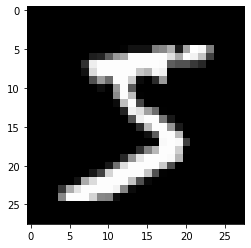

0.0


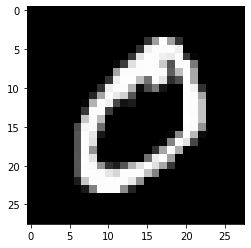

4.0


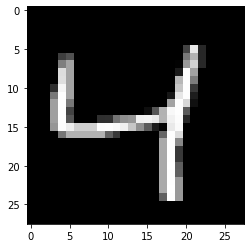

1.0


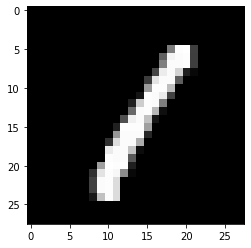

9.0


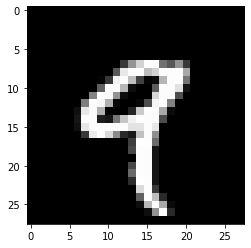

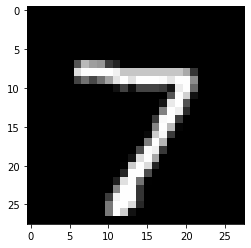

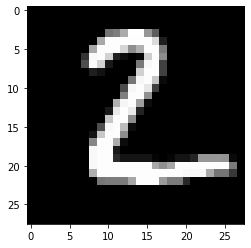

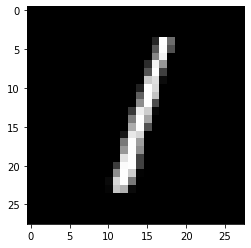

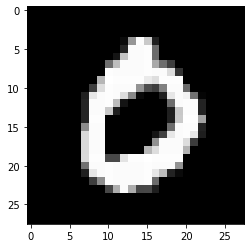

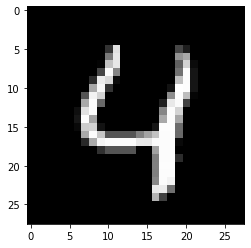

In [3]:
#读取5张照片验证
for i in range(5):
    print(train_labels[i])
    plt.imshow(train_images[i], cmap='gray')
    plt.pause(0.000001)
    plt.show()
#读取5张测试集
for i in range(5):
    plt.imshow(test_images[i], cmap='gray')
    plt.pause(0.000001)
    plt.show()

## 预处理——零均值化

In [4]:
for i in range(60000):
    mean_image = np.mean(train_images[i], axis=0)
    train_images[i] = train_images[i] - mean_image
for i in range(10000):
    mean_image = np.mean(test_images[i], axis=0)
    test_images[i] = test_images[i] - mean_image

train_images = np.resize(train_images, (60000,784))        #60000*784，用于LDA
train_labels = np.array([int(i) for i in train_labels])    #60000


## 划分训练集58000、验证集2000

In [5]:
#从训练集中取最后2000个用作验证集，剩余58000个作为训练集
val_images = []
val_label = []
for k in range(2000):
    val_images.append(train_images[58000+k])
    val_label.append(train_labels[58000+k])
val_images = np.array(val_images)
val = zip(val_images,np.array(val_label))
#train_data = train_data[0:58000]
train_images = train_images[0:58000]
train_labels = train_labels[0:58000]

## 线性分类器 class LinearClassifier

In [6]:
class LinearClassifier(object):
    
    def __init__(self):
        self.W = None

    # 训练
    def train(self, X, y, learning_rate=1e-3, reg=1e-4, iter_nums=100,batch_size=500):
        X = np.hstack([X, np.ones((X.shape[0], 1))]) #增加常数项1，变为785维
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        
        if self.W is None:
            self.W = 0.01 * np.random.randn(dim, num_classes)

        loss_list = []
        for it in range(iter_nums):
            X_batch = None
            y_batch = None
            batchrows = np.random.choice(num_train, batch_size)
            X_batch = X[batchrows] 
            y_batch = y[batchrows]
            loss, grad = self.svm_loss(X_batch, y_batch, reg)
            loss_list.append(loss)

      # update
            self.W -= learning_rate * grad
            if  it % 1000 == 0:
                print('iteration %d / %d: loss %f' % (it, iter_nums, loss))
        return loss_list
    
    #SVM loss
    def svm_loss(self, X, y, reg):
        loss = 0.0
        W = self.W
        dW = np.zeros(W.shape) # 梯度初始化
        num_classes = W.shape[1]
        num_train = X.shape[0]

        scores = X.dot(W) # (1, 10)
        correct_scores = scores[ np.arange(num_train),  y] 
        correct_scores = np.tile(correct_scores.reshape(num_train, 1) , (1, num_classes)) # 复制为10列
        margin = scores - correct_scores + 1

        margin[np.arange(num_train), y] = 0 # 正确的分类loss为0
        margin[margin < 0] = 0# 小于0的loss为0
        loss = np.sum(margin) / num_train
        loss += reg * np.sum(W * W)
  
        margin[ margin > 0 ] = 1  # 大于0的是造成损失的权重
        row_sum = np.sum( margin, axis = 1 ) # 按行求和，每次遍历里，正确的分类都被减一次
        margin[np.arange( num_train ), y] = -row_sum # 正确分类是负的，-X
        # 点积
        dW += np.dot(X.T, margin) / num_train + reg * W  
        return loss, dW
    
    def predict(self, X):
        X = np.append(X,1) #增加常数项1，变为785维
        y_pred = np.zeros(X.shape[0])
        y_pred = np.argmax(np.dot( X, self.W ))
        return y_pred
    
    def evaluate(self, test_data):
        #测试准确率
        print("accuracy:")
        test_results = [(self.predict(x), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)/len(test_results)
  


## 创建一个线性分类器分类，验证准确率

In [7]:
classifier1 = LinearClassifier()
t = classifier1.train(train_images,train_labels,iter_nums=10000)
print(classifier1.evaluate(val))

iteration 0 / 10000: loss 109.872494
iteration 1000 / 10000: loss 56.737715
iteration 2000 / 10000: loss 7.923194
iteration 3000 / 10000: loss 3.395775
iteration 4000 / 10000: loss 4.517595
iteration 5000 / 10000: loss 4.435704
iteration 6000 / 10000: loss 3.199726
iteration 7000 / 10000: loss 3.239889
iteration 8000 / 10000: loss 7.475852
iteration 9000 / 10000: loss 4.922936
accuracy:
0.9305


# LDA

In [8]:
class LDA(object):
    def __init__(self,class_num,low_dim):
        self.num = class_num
        self.k = low_dim
    
    def cal_sw_sb(self,data,label,eta):
        xa = data
        y = label
        #所有元素的平均值
        ua=np.array([np.mean(xa,axis=0)])
        n=xa.shape[1]
        #存储x值
        x=[[]for i in range(self.num)]
        u=[[]for i in range(self.num)]
        sw=np.zeros([n,n])
        sb=np.zeros([n,n])
        for i in range(y.shape[0]):
            x[y[i]].append(xa[i])
        for i in range(self.num):
            x[i]=np.array(x[i])
            u[i]=np.array([np.mean(x[i],axis=0)])
         #去中心化,计算Sw
        for i in range(self.num):
            for k in range(len(x[i])):
                x[i][k]-=np.resize(u[i],784)
            sw=sw+np.dot(x[i].T,x[i])
            sb=sb+x[i].shape[0]*np.dot((u[i]-ua).T,(u[i]-ua))
        sw+=np.diag([eta] * 784) #增加扰动，使矩阵可逆
        return sw,sb

    def lda(self,data,label,eta):
        sw,sb = self.cal_sw_sb(data,label,eta)
        eig_value,eig_vec=np.linalg.eig(np.dot(np.linalg.inv(sw),sb))
        #对特征值进行排序，返回索引
        index=np.argsort(eig_value)
        #取k个目标特征向量
        eig_k=eig_vec[:,index[:-self.k-1:-1]]
        return eig_k
    
    def fit(self,data,eig_k):
        #8维
        d2 = []
        for i in range(len(data)):
            d2.append([float(np.dot(data[i],eig_k[:,0])),float(np.dot(data[i],eig_k[:,1])),float(np.dot(data[i],eig_k[:,2])),float(np.dot(data[i],eig_k[:,3])),float(np.dot(data[i],eig_k[:,4])),float(np.dot(data[i],eig_k[:,5])),float(np.dot(data[i],eig_k[:,6])),float(np.dot(data[i],eig_k[:,7]))])
        return np.array(d2)


In [9]:
lda_mnist = LDA(class_num = 10,low_dim = 9)
eig_vec_k = lda_mnist.lda(train_images,train_labels,eta = 1.05)

## 取两维进行可视化

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


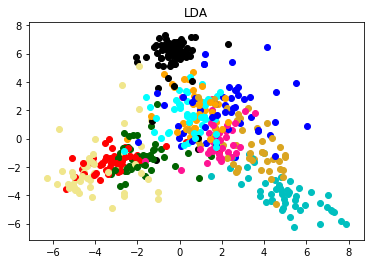

In [10]:
color = ['c','black','blue','cyan','darkgreen','deeppink','goldenrod','khaki','orange','red']
#取500个样本点进行lda后数据的可视化
for i in range(500):
    plt.scatter(np.dot(train_images[i],eig_vec_k[:,0]),np.dot(train_images[i],eig_vec_k[:,1]),c=color[train_labels[i]] )

plt.title("LDA")
plt.show()


In [11]:
#对数据集降维
low_train = lda_mnist.fit(train_images,eig_vec_k)
low_val = lda_mnist.fit(val_images,eig_vec_k)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


## 降维后验证线性分类准确率

In [12]:
classifier2 = LinearClassifier()
t = classifier2.train(low_train[0:58000],train_labels,iter_nums=10000)
classifier2.evaluate(zip(low_val,val_label))

iteration 0 / 10000: loss 8.996272
iteration 1000 / 10000: loss 0.635512
iteration 2000 / 10000: loss 0.758179
iteration 3000 / 10000: loss 0.592629
iteration 4000 / 10000: loss 0.460698
iteration 5000 / 10000: loss 0.518776
iteration 6000 / 10000: loss 0.593623
iteration 7000 / 10000: loss 0.706576
iteration 8000 / 10000: loss 0.650366
iteration 9000 / 10000: loss 0.604380
accuracy:


0.9195

In [13]:
test_images = np.resize(test_images, (10000,784))        #10000*784，用于LDA
def pre_dict(data,classifier):
    '''
    在测试集上预测
    '''
    results = []
    for i in data:
        results.append(classifier.predict(i))
    return results
def write(path,results):
    '''
    写入csv文件
    '''
    f = open(path,'w',encoding='utf-8')
    csv_writer = csv.writer(f)
    for i in range(len(results)):
        csv_writer.writerow([('./test/'+str(i)+'.jpg'), results[i]])
    print('finishied')

## 将测试集上结果写入csv

In [14]:
write('task1_test_prediction.csv', pre_dict(test_images,classifier1))
write('task2_test_prediction.csv', pre_dict(lda_mnist.fit(test_images,eig_vec_k),classifier2))

finishied


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


finishied
